# Housing Market Analysis 



## I. Setting up our environment

### 1. Importing missing packages

In [ ]:
!pip install geopandas
!pip install ggplot
!pip install pdpbox
!pip install scikit-misc

### 2. Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from google.colab import drive
from pdpbox import pdp
from plotnine import *

from sklearn.metrics import r2_score, mean_absolute_error ,mean_squared_error
from sklearn.model_selection import cross_val_score ,train_test_split ,GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge ,Lasso
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

### 3. Helper function 
We're going to use this function in order to display the metrics for a specific model in a non redundant way 

In [ ]:
def performance_metrics(features,  y_true, y_pred, th=0):
  # this function returns a dataframe containing the metric for a specific model
  # th : threshold default value = 0 : indicates the minimal value of correlation with the target when selecting features 
  total_features = []
  total_features_name = []
  selected_correlation_value = []
  r2_scores = []
  mae_value = []
  mse_value = []
  score = r2_score(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)    
  mse = mean_squared_error(y_true, y_pred)
  total_features.append(len(features)-1)
  total_features_name.append(str(features))
  selected_correlation_value.append(th)
  r2_scores.append(score)
  mae_value.append(mae)
  mse_value.append(mse)
  metrics_dataframe = pd.DataFrame(data= [total_features_name, total_features, r2_scores, mae_value, mse_value],
                                    index = ['features name', '#feature', 'r2_score', 'MAE', 'MSE'])
  return metrics_dataframe.T

### 4. Mounting colab with my drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## II. Data processing & exploration

### 1. Import the data

In [ ]:
boston = pd.read_csv('/content/drive/My Drive/AIHack/boston_corrected.csv')

### 2. Explore & clean the dataset

In [ ]:
boston.head()

,TOWN,TOWNNO,TRACT,LON,LAT,MEDV,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,Nahant,0,2011,-70.955,42.2550,24.0,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,Swampscott,1,2021,-70.950,42.2875,21.6,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,Swampscott,1,2022,-70.936,42.2830,34.7,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,Marblehead,2,2031,-70.928,42.2930,33.4,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,Marblehead,2,2032,-70.922,42.2980,36.2,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [ ]:
boston.isnull().sum()

TOWN       0
TOWNNO     0
TRACT      0
LON        0
LAT        0
MEDV       0
CMEDV      0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [ ]:
boston.describe()

,TOWNNO,TRACT,LON,LAT,MEDV,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,47.531621,2700.357708,-71.056389,42.216440,22.532806,22.528854,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,27.571401,1380.038110,0.075405,0.061777,9.197104,9.182176,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.000000,1.000000,-71.289500,42.030000,5.000000,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,26.250000,1303.250000,-71.093225,42.180775,17.025000,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,42.000000,3393.500000,-71.052900,42.218100,21.200000,21.200000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,78.000000,3739.750000,-71.019625,42.252250,25.000000,25.000000,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,91.000000,5082.000000,-70.810000,42.381000,50.000000,50.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


### 3. Identifying features & target 

In [ ]:
y = boston['CMEDV']
data = boston.drop(columns = ['MEDV','CMEDV','TOWN'])
X = data
# we don't need the town variable since we have the town number
# MEDV must not be included in the features because it's highly correlated with our target (since it has the values of the target before correction )
data['Price']=y
data.head()

,TOWNNO,TRACT,LON,LAT,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0,2011,-70.955,42.2550,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,1,2021,-70.950,42.2875,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,1,2022,-70.936,42.2830,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,2,2031,-70.928,42.2930,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,2,2032,-70.922,42.2980,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### 4. Discovering correlated variables

#### Creating the correlation matrix

In [ ]:
corrmat = data.corr()
corrmat

,TOWNNO,TRACT,LON,LAT,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
TOWNNO,1.000000,-0.455757,-0.000627,-0.631648,0.447920,-0.123970,0.434426,-0.009220,0.429399,-0.117334,0.235141,-0.327280,0.724060,0.707982,0.341111,-0.306517,0.296600,-0.265134
TRACT,-0.455757,1.000000,-0.220892,-0.225541,-0.547165,0.367294,-0.575706,0.041356,-0.569808,0.305207,-0.487467,0.496842,-0.828830,-0.793603,-0.532679,0.365047,-0.522486,0.428252
LON,-0.000627,-0.220892,1.000000,0.143054,0.065101,-0.218081,0.062702,-0.175619,0.160871,-0.257110,0.204739,-0.011243,0.034067,0.050663,0.312602,-0.018300,0.195630,-0.322947
LAT,-0.631648,-0.225541,0.143054,1.000000,-0.084293,-0.129667,-0.041093,-0.044726,-0.068600,-0.069317,0.079035,-0.082981,-0.207013,-0.167718,-0.004527,0.105254,0.045660,0.006826
CRIM,0.447920,-0.547165,0.065101,-0.084293,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.389582
ZN,-0.123970,0.367294,-0.218081,-0.129667,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360386
INDUS,0.434426,-0.575706,0.062702,-0.041093,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.484754
CHAS,-0.009220,0.041356,-0.175619,-0.044726,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175663
NOX,0.429399,-0.569808,0.160871,-0.068600,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.429300
RM,-0.117334,0.305207,-0.257110,-0.069317,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.696304


#### Visualizing the correlation matrix

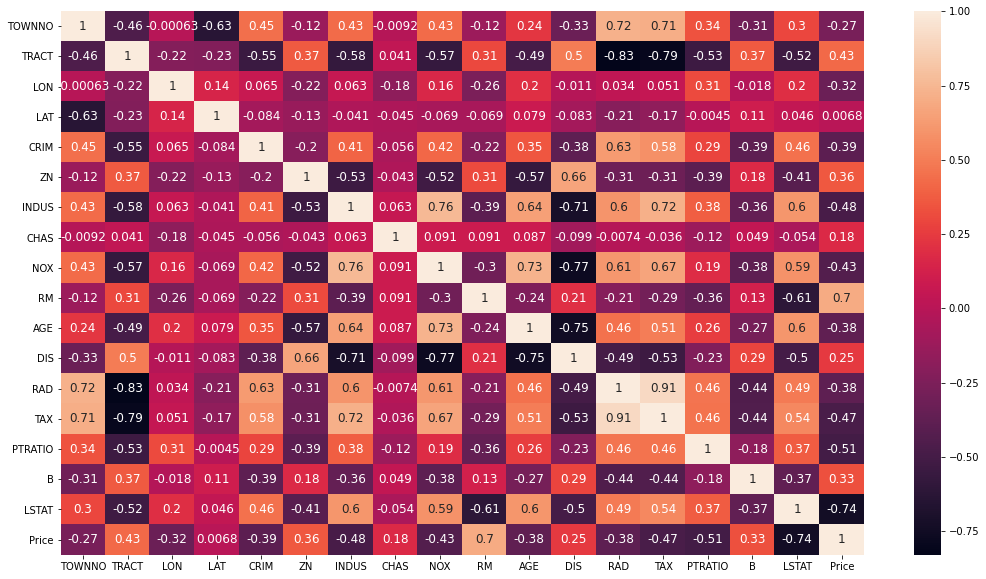

In [ ]:
fig, ax = plt.subplots(figsize = (18, 10))
sns.heatmap(corrmat, annot = True, annot_kws={'size': 12})
plt.show()

#### Visualize linear correlations.

###### Linear correlation between Price & INDUS

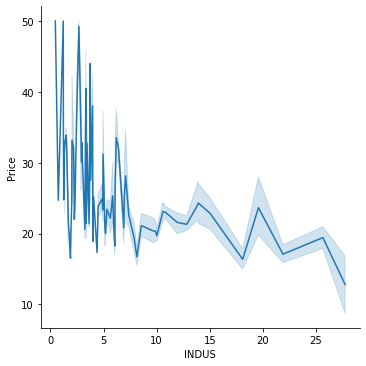

In [ ]:
sns.relplot(x="INDUS", y="Price",kind="line", data=data.sort_values(by = 'Price', ascending=False));

###### Linear correlation between LSTAT & Price

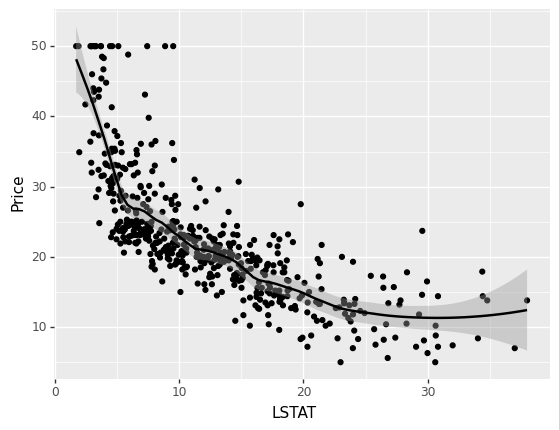

<ggplot: (-9223363299132990299)>

In [ ]:
ggplot(data, aes('LSTAT', 'Price')) + geom_point() + geom_smooth(span = 0.3)

###### Linear correlation between RAD & TRACT

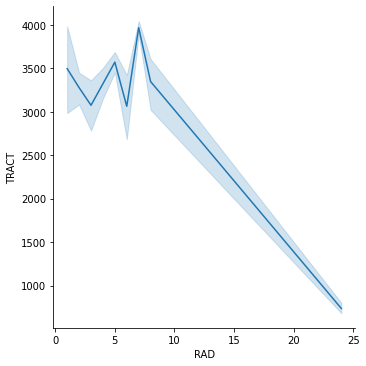

In [ ]:
sns.relplot(x="RAD", y="TRACT",kind="line", data=data.sort_values(by = 'Price', ascending=False));

###### Linear correlation between RM & Price

 

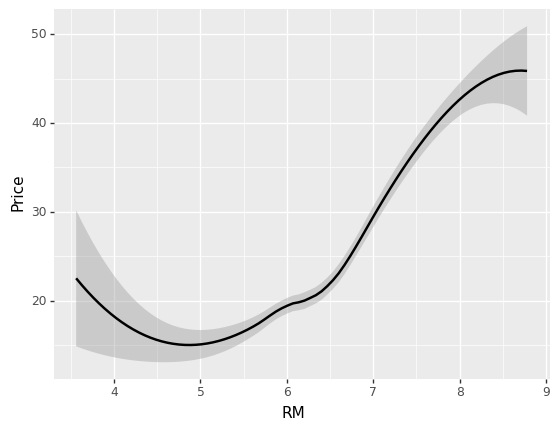

<ggplot: (-9223363299136006214)>

In [ ]:
ggplot(data, aes('RM', 'Price'))+stat_smooth(se=True, method='loess')

### Importance of scaling
In order to get better visualisations and discover the correlations between variables , we use **StandardScaler** which standardizes a feature by subtracting the mean and then scaling to unit variance. 
To identify its impact , we suggest visualizing the correlation between 'DIS' and 'NOX' before and after scaling. 

In [ ]:
from sklearn.preprocessing import StandardScaler
boston_df = boston.drop(columns = ['TOWN','MEDV'])
scaled_features = StandardScaler().fit_transform(boston_df.values)
scaled_features_df = pd.DataFrame(scaled_features, index=boston_df.index, columns=boston_df.columns)
X_scaled = scaled_features_df.drop(columns=['CMEDV'])
y_scaled = scaled_features_df['CMEDV']
data_scaled = X_scaled
data_scaled['Price'] = y_scaled
data_scaled.head()


,TOWNNO,TRACT,LON,LAT,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,-1.725653,-0.500015,1.345913,0.624791,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,0.160376
1,-1.689347,-0.492762,1.412287,1.151396,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,-0.101258
2,-1.689347,-0.492036,1.598134,1.078482,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,1.326830
3,-1.653042,-0.485508,1.704333,1.240514,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,1.185112
4,-1.653042,-0.484783,1.783981,1.321530,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,1.490352


Ploting the graphs of DIS and NOX, since they are highly correlated 

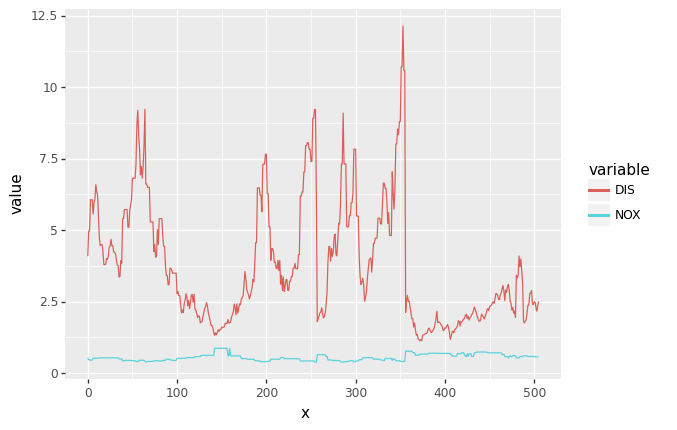

<ggplot: (8737718748259)>

In [ ]:
df=boston[['DIS','NOX']]
df['x'] = df.index
df = pd.melt(df, id_vars='x')

ggplot(aes(x='x', y='value', color='variable'), df) + \
      geom_line()

=> the correclation isn't clear here because the two variable don't flactuate in the same interval.

**We need to use the scaled data.**

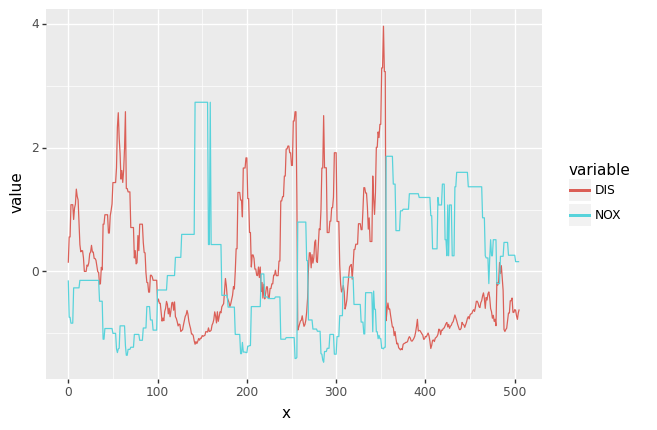

<ggplot: (-9223363299135814242)>

In [ ]:
df=scaled_features_df[['DIS','NOX']]
df['x'] = df.index
df = pd.melt(df, id_vars='x')

ggplot(aes(x='x', y='value', color='variable'), df) + \
      geom_line()

***Interpretation*** : its clear from the graph that they move in opposite directions

In [ ]:
gdf = gpd.GeoDataFrame(
    boston[["TOWN", "LAT","LON","CMEDV"]], geometry=gpd.points_from_xy(boston.LON, boston.LAT))
gdf.head()

,TOWN,LAT,LON,CMEDV,geometry
0,Nahant,42.2550,-70.955,24.0,POINT (-70.95500 42.25500)
1,Swampscott,42.2875,-70.950,21.6,POINT (-70.95000 42.28750)
2,Swampscott,42.2830,-70.936,34.7,POINT (-70.93600 42.28300)
3,Marblehead,42.2930,-70.928,33.4,POINT (-70.92800 42.29300)
4,Marblehead,42.2980,-70.922,36.2,POINT (-70.92200 42.29800)


In [ ]:
gdf.describe()

,LAT,LON,CMEDV
count,506.000000,506.000000,506.000000
mean,42.216440,-71.056389,22.528854
std,0.061777,0.075405,9.182176
min,42.030000,-71.289500,5.000000
25%,42.180775,-71.093225,17.025000
50%,42.218100,-71.052900,21.200000
75%,42.252250,-71.019625,25.000000
max,42.381000,-70.810000,50.000000


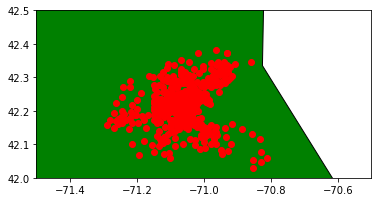

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# We restrict to US of America.
ax = world[world.name == 'United States of America'].plot(
    color='green', edgecolor='black' )

gdf.plot(ax=ax, color='red' )
plt.axis([-71.5, -70.5, 42, 42.5])


plt.show()

In [ ]:
corrmat.index.values

array(['TOWNNO', 'TRACT', 'LON', 'LAT', 'CRIM', 'ZN', 'INDUS', 'CHAS',
       'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT',
       'Price'], dtype=object)

### Data processing & exploration

#### Target value distribution

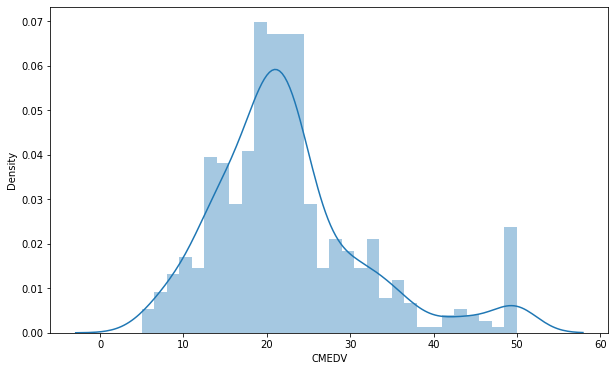

In [ ]:
plt.figure(figsize=(10, 6))
sns.distplot(boston['CMEDV'],bins=30)

#### Distribution of housing prices by town

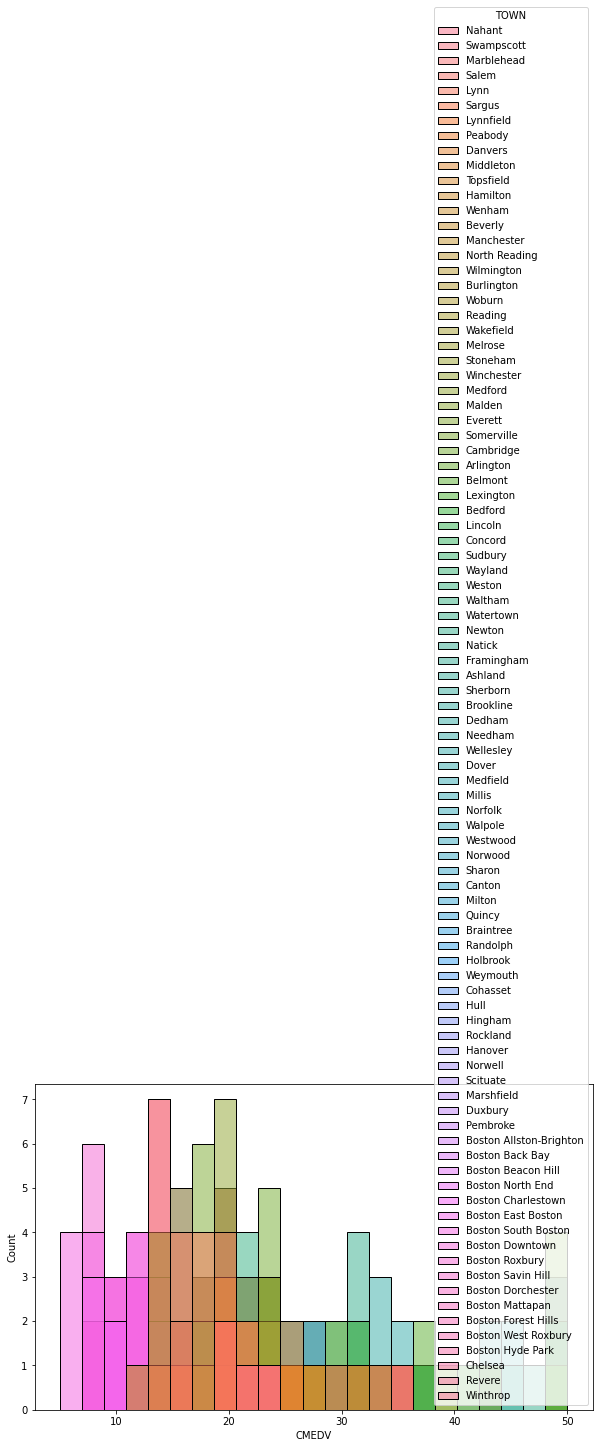

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=boston, x="CMEDV", hue="TOWN" )


## III. Regression on all the features

### 1. Train Test split for unscaled and scaled data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='Price'), y, test_size = 0.33, random_state = 0)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_scaled.drop(columns='Price'), y_scaled, test_size = 0.33, random_state = 0)


### 2. Linear Regression on all the features

In [ ]:
def linear_regression_model(X_train, X_test, y_train, y_test, scaling):

  model = LinearRegression()
  model.fit(X_train, y_train)
  y_predict = model.predict(X_test)
  df = pd.DataFrame(data = [y_predict, y_test])
  df.T
  results = performance_metrics(X_train.columns, y_test, y_predict)
  results['model'] = 'linear regression'
  results['data'] = scaling
  return results

#### Unscaled Data

In [ ]:
lr_ns = linear_regression_model(X_train, X_test, y_train, y_test, 'unscaled')
lr_ns

,features name,#feature,r2_score,MAE,MSE,model,data
0,"Index(['TOWNNO', 'TRACT', 'LON', 'LAT', 'CRIM'...",16,0.68421,3.44442,25.3083,linear regression,unscaled


#### Scaled Data


In [ ]:
lr_s = linear_regression_model(X_train_s, X_test_s, y_train_s, y_test_s, 'scaled')
lr_s

,features name,#feature,r2_score,MAE,MSE,model,data
0,"Index(['TOWNNO', 'TRACT', 'LON', 'LAT', 'CRIM'...",16,0.68421,0.375492,0.300768,linear regression,scaled


### 3. Linear Regression with Polynomial Features

#### Unscaled Data

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 2)


def regressor_poly2_model(X_train, X_test, y_train, y_test, scaling):
  X_poly = poly_reg.fit_transform(X_train)
  poly_reg.fit(X_poly, y_train)
  regressor_poly2 = LinearRegression()

  regressor_poly2.fit(X_poly, y_train)

  # Predicting Cross Validation Score the Test set results
  cv_poly2 = cross_val_score(estimator = regressor_poly2, X = X_train, y = y_train, cv = 10)

  # Predicting R2 Score the Train set results
  y_pred_poly2_train = regressor_poly2.predict(poly_reg.fit_transform(X_train))
  r2_score_poly2_train = r2_score(y_train, y_pred_poly2_train)

  # Predicting R2 Score the Test set results
  y_pred_poly2_test = regressor_poly2.predict(poly_reg.fit_transform(X_test))
  r2_score_poly2_test = r2_score(y_test, y_pred_poly2_test)

  results = performance_metrics(X_train.columns, y_test, y_pred_poly2_test)
  results['model'] = 'linear regression with polynomial features'
  results['data'] = scaling
  return results

In [ ]:
lr_ns_p2 = regressor_poly2_model(X_train, X_test, y_train, y_test, 'unscaled')
lr_ns_p2

,features name,#feature,r2_score,MAE,MSE,model,data
0,"Index(['TOWNNO', 'TRACT', 'LON', 'LAT', 'CRIM'...",16,0.678643,3.32275,25.7544,linear regression with polynomial features,unscaled


#### Scaled Data

In [ ]:
lr_s_p2 = regressor_poly2_model(X_train_s, X_test_s, y_train_s, y_test_s, 'scaled')
lr_s_p2

,features name,#feature,r2_score,MAE,MSE,model,data
0,"Index(['TOWNNO', 'TRACT', 'LON', 'LAT', 'CRIM'...",16,0.686518,0.357982,0.29857,linear regression with polynomial features,scaled


### Ridge model

In [ ]:

def ridge_model(X_train, X_test, y_train, y_test, steps, scaling):
  
  ridge_pipe = Pipeline(steps)
  ridge_pipe.fit(X_train, y_train)
  # Predicting Cross Validation Score the Test set results
  cv_ridge = cross_val_score(estimator = ridge_pipe, X = X_train, y = y_train.ravel(), cv = 10)

  y_pred_ridge_test = ridge_pipe.predict(X_test)

  results = performance_metrics(X_train.columns, y_test, y_pred_ridge_test)
  results['model'] = 'Ridge'
  results['data'] = scaling
  return results





#### Unscaled data

In [ ]:
ridge_ns = ridge_model(X_train, X_test, y_train, y_test, [
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge(alpha=3.8, fit_intercept=True))
], "unscaled")
ridge_ns

,features name,#feature,r2_score,MAE,MSE,model,data
0,"Index(['TOWNNO', 'TRACT', 'LON', 'LAT', 'CRIM'...",16,0.772835,2.77662,18.2056,Ridge,unscaled


#### Scaled Data

In [ ]:
ridge_s = ridge_model(X_train, X_test, y_train, y_test, [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge(alpha=3.8, fit_intercept=True))
], "scaled")
ridge_s

,features name,#feature,r2_score,MAE,MSE,model,data
0,"Index(['TOWNNO', 'TRACT', 'LON', 'LAT', 'CRIM'...",16,0.802146,2.50413,15.8566,Ridge,scaled


### Lasso Model

In [ ]:


def lasso_model(X_train, X_test, y_train, y_test, steps, scaling):
  
  lasso_pipe = Pipeline(steps)
  lasso_pipe.fit(X_train, y_train)
  # Predicting Cross Validation Score
  cv_lasso = cross_val_score(estimator = lasso_pipe, X = X_train, y = y_train, cv = 10)
 
  y_pred_lasso_test = lasso_pipe.predict(X_test)
  
  results = performance_metrics(X_train.columns, y_test, y_pred_lasso_test)
  results['model'] = 'Lasso'
  results['data'] = scaling
  return results


#### Unscaled Data

In [ ]:

lasso_ns = lasso_model(X_train, X_test, y_train, y_test, [
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Lasso(alpha=0.012, fit_intercept=True, max_iter=3000))
], "unscaled")
lasso_ns

,features name,#feature,r2_score,MAE,MSE,model,data
0,"Index(['TOWNNO', 'TRACT', 'LON', 'LAT', 'CRIM'...",16,0.734733,2.83919,21.2592,Lasso,unscaled


#### Scaled Data

In [ ]:
lasso_s = lasso_model(X_train, X_test, y_train, y_test,[
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Lasso(alpha=0.012, fit_intercept=True, max_iter=3000))
], "scaled")
lasso_s

,features name,#feature,r2_score,MAE,MSE,model,data
0,"Index(['TOWNNO', 'TRACT', 'LON', 'LAT', 'CRIM'...",16,0.803371,2.49849,15.7584,Lasso,scaled


### Random Forest Regressor

In [ ]:
def rf_model(X_train, X_test, y_train, y_test, scaling):

  rf = RandomForestRegressor(n_estimators = 400, min_samples_leaf=0.12, random_state=123)
  rf.fit(X_train, y_train)
  rf_pred = rf.predict(X_test)
  results = performance_metrics(X_train.columns, y_test, rf_pred)
  results['model'] = 'Random Forest Regressor'
  results['data'] = scaling

  return results



#### Unscaled Data

In [ ]:
rf_ns = rf_model(X_train, X_test, y_train, y_test, "unscaled")
rf_ns

,features name,#feature,r2_score,MAE,MSE,model,data
0,"Index(['TOWNNO', 'TRACT', 'LON', 'LAT', 'CRIM'...",16,0.628536,3.67323,29.7702,Random Forest Regressor,unscaled


#### Scaled Data

In [ ]:
rf_s = rf_model(X_train_s, X_test_s, y_train_s, y_test_s, "scaled")
rf_s

,features name,#feature,r2_score,MAE,MSE,model,data
0,"Index(['TOWNNO', 'TRACT', 'LON', 'LAT', 'CRIM'...",16,0.628531,0.400452,0.353798,Random Forest Regressor,scaled


### XGBoost with GridSearch

In [ ]:
gbm_param_grid = {'learning rate': [0.01, 0.1, 0.5, 0.9], 'n_estimators': [200], 'subsample':[0.3,0.5,0.9]}
gbm = xgb.XGBRegressor()
grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, scoring='neg_mean_squared_error', cv=4, verbose=1)

In [ ]:
grid_mse.fit(X, y)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[10:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[10:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    4.8s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning rate': [0.01, 0.1, 0.5, 0.9],
                         'n_estimators': [200], 'subsample': [0.3, 

In [ ]:
#Print best performing parameters and their RMSE scores
print('Best parameters found: ', grid_mse.best_params_)
print('Lowerst RMSE found: ', np.sqrt(np.sqrt(np.abs(grid_mse.best_score_))))

Best parameters found:  {'learning rate': 0.01, 'n_estimators': 200, 'subsample': 0.9}
Lowerst RMSE found:  0.8186648095236909


In [ ]:
gbm = xgb.XGBRegressor(learning_rate= 0.01, n_estimators= 200, subsample= 0.3)

In [ ]:
gbm.fit(X_train,y_train)

preds = gbm.predict(X_test)

xgb_ns = performance_metrics(X_train.columns, y_test, preds)
xgb_ns['model'] = 'XGBoost Regressor'
xgb_ns['data'] = 'unscaled'
xgb_ns

[10:38:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,features name,#feature,r2_score,MAE,MSE,model,data
0,"Index(['TOWNNO', 'TRACT', 'LON', 'LAT', 'CRIM'...",16,0.559391,3.8693,35.3117,XGBoost Regressor,unscaled


## IV. Feature Selection / Model Selection

In [ ]:
dfs = [lr_ns, lr_s, lr_ns_p2, lr_s_p2, ridge_ns, ridge_s, lasso_ns, lasso_s, rf_ns, rf_s, xgb_ns]

results = pd.concat(dfs ,ignore_index=True)
a = results.sort_values(by='r2_score', ascending =False)
a.to_csv('/content/drive/My Drive/AIHack/models.csv' , index = False, header=True)

**From this dataframe, we ca, see that the lasso algorithm with scaled dataset is the best (highest r2_score and lowest MSE), let's try to use a subset of these columns and see if it gets better.**

### Feature Selection

In [ ]:
def getCorrelatedFeature(corrdata, threshold):
    feature = []
    value = []
    
    for i, index in enumerate(corrdata.index):
        if abs(corrdata[index])> threshold:
            feature.append(index)
            value.append(corrdata[index])
            
    df = pd.DataFrame(data = value, index = feature, columns=['Corr Value'])
    return df

In [ ]:
threshold = 0.45
corr_value = getCorrelatedFeature(corrmat['Price'], threshold)
corr_value

,Corr Value
INDUS,-0.484754
RM,0.696304
TAX,-0.471979
PTRATIO,-0.505655
LSTAT,-0.740836
Price,1.000000


In [ ]:
correlated_data = data[corr_value.index]
correlated_data.head()

,INDUS,RM,TAX,PTRATIO,LSTAT,Price
0,2.31,6.575,296,15.3,4.98,24.0
1,7.07,6.421,242,17.8,9.14,21.6
2,7.07,7.185,242,17.8,4.03,34.7
3,2.18,6.998,222,18.7,2.94,33.4
4,2.18,7.147,222,18.7,5.33,36.2


In [ ]:
#[note] fs : feature selection
X_fs = correlated_data.drop(labels=['Price'], axis = 1)
y_fs = correlated_data['Price']
X.head()

,TOWNNO,TRACT,LON,LAT,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0,2011,-70.955,42.2550,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,1,2021,-70.950,42.2875,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,1,2022,-70.936,42.2830,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,2,2031,-70.928,42.2930,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,2,2032,-70.922,42.2980,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fs, y_fs, test_size = 0.33)


lasso_s_fs = lasso_model(X_train, X_test, y_train, y_test,[
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Lasso(alpha=0.012, fit_intercept=True, max_iter=3000))
], "scaled")
lasso_s_fs

,features name,#feature,r2_score,MAE,MSE,model,data
0,"Index(['INDUS', 'RM', 'TAX', 'PTRATIO', 'LSTAT...",4,0.812782,2.68933,15.5122,Lasso,scaled


In [ ]:
lasso_ns_fs = lasso_model(X_train, X_test, y_train, y_test,[
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Lasso(alpha=0.012, fit_intercept=True, max_iter=3000))
], "unscaled")
lasso_ns_fs

,features name,#feature,r2_score,MAE,MSE,model,data
0,"Index(['INDUS', 'RM', 'TAX', 'PTRATIO', 'LSTAT...",4,0.811319,2.72196,15.6334,Lasso,scaled


In [ ]:
ridge_ns_fs = ridge_model(X_train, X_test, y_train, y_test, [
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge(alpha=3.8, fit_intercept=True))
], "unscaled")
ridge_ns_fs

,features name,#feature,r2_score,MAE,MSE,model,data
0,"Index(['INDUS', 'RM', 'TAX', 'PTRATIO', 'LSTAT...",4,0.808555,2.7361,15.8624,Ridge,unscaled


In [ ]:
ridge_s_fs = ridge_model(X_train, X_test, y_train, y_test, [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge(alpha=3.8, fit_intercept=True))
], "scaled")
ridge_s_fs

,features name,#feature,r2_score,MAE,MSE,model,data
0,"Index(['INDUS', 'RM', 'TAX', 'PTRATIO', 'LSTAT...",4,0.811679,2.67877,15.6036,Ridge,scaled


### Model Selection

In [ ]:
results = pd.concat([results,lasso_s_fs,lasso_ns_fs,ridge_ns_fs,ridge_s_fs], ignore_index=True)
all_models = results.sort_values(by='r2_score', ascending =False)
all_models.to_csv('/content/drive/My Drive/AIHack/all.models.csv' , index = False, header=True)

In [ ]:
all_models.head()

,features name,#feature,r2_score,MAE,MSE,model,data
11,"Index(['INDUS', 'RM', 'TAX', 'PTRATIO', 'LSTAT...",4,0.812782,2.68933,15.5122,Lasso,scaled
14,"Index(['INDUS', 'RM', 'TAX', 'PTRATIO', 'LSTAT...",4,0.811679,2.67877,15.6036,Ridge,scaled
12,"Index(['INDUS', 'RM', 'TAX', 'PTRATIO', 'LSTAT...",4,0.811319,2.72196,15.6334,Lasso,scaled
13,"Index(['INDUS', 'RM', 'TAX', 'PTRATIO', 'LSTAT...",4,0.808555,2.7361,15.8624,Ridge,unscaled
7,"Index(['TOWNNO', 'TRACT', 'LON', 'LAT', 'CRIM'...",16,0.803371,2.49849,15.7584,Lasso,scaled


**We get better result of r2_score with feature selection and the MSE decreased a little bit for the Lasso scaled model.**